<a href="https://colab.research.google.com/github/rishipython/StockTradingAI/blob/main/Q_Learning_Stock_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 11.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=947a99b06d416c2f8f70423096711ad01e68773f1c5873244c0223614567c4a4
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
import datetime
from datetime import date
import yfinance as yf
from matplotlib import pyplot as plt
import keras
from keras.initializers import HeUniform
from keras.layers import Input, Dense
from keras.losses import Huber
from keras.optimizers import Adam
from keras.models import Sequential, Model
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from pickle import dump, load
import numpy as np
import random
from collections import deque
from IPython.display import clear_output
import os

In [ ]:
# Access GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon May 24 03:12:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Access more memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# See if Tensorflow is using GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_dir = f"{os.sep}content{os.sep}drive{os.sep}My Drive{os.sep}S&P 500 Stock Trading{os.sep}"

In [ ]:
ls "/content/drive/My Drive/S&P 500 Stock Trading/"

model_1/  model_4/          x.npy        x_val.npy   y_train.npy
model_2/  normalizer_x.pkl  x_test.npy   y.npy       y_val.npy
model_3/  normalizer_y.pkl  x_train.npy  y_test.npy


# Get S&P 500 Stock Data

In [ ]:
class Company:
  def __init__(self, symbol, name, stock):
    self.symbol = symbol
    self.name = name
    self.stock = stock

In [ ]:
symbols = []
names = []

In [ ]:
today = datetime.datetime.now()
print("Today is " + str(today.strftime("%b-%d-%Y")))
fifteen_years_ago = today - datetime.timedelta(days=15*365)
print("The day fifteen years ago was " + str(fifteen_years_ago.strftime("%b-%d-%Y")))

Today is May-24-2021
The day fifteen years ago was May-28-2006


In [ ]:
# Get symbols and names of all S&P 500 companies started 15 years or more from today
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
for i in range(len(df)):
  if df.loc[i, "Symbol"] == "BF.B": # finance can't find data for BF.B, symbol may be delisted
    continue
  date_first_added = df.loc[i, "Date first added"]
  if not isinstance(date_first_added, str):
    continue
  date_first_added = date_first_added[:10]
  date_first_added = datetime.datetime.strptime(date_first_added, "%Y-%m-%d")
  if date_first_added > fifteen_years_ago:
    continue
  symbols.append(df.loc[i, "Symbol"])
  names.append(df.loc[i, "Security"])

In [ ]:
print(len(symbols))
print(len(names))

205
205


In [ ]:
str_symbols = " ".join(symbols)

In [ ]:
data = yf.download(str_symbols, start=fifteen_years_ago, end=today)

[*********************100%***********************]  205 of 205 completed


In [ ]:
data.head()

Adj Close                       ...   Volume                 
                    A      AAPL        ABC  ...      YUM      ZBH    ZION
Date                                        ...                          
2006-05-30  21.045671  1.880117  17.134293  ...  2669607  1646000  240600
2006-05-31  21.545885  1.835586  17.272976  ...  3746241  1355200  565800
2006-06-01  21.632332  1.909291  17.372042  ...  4551908  1418000  440100
2006-06-02  21.934923  1.893629  17.328453  ...  3247985  1549700  591900
2006-06-05  21.206238  1.842649  17.031263  ...  2444543  1501900  662200

[5 rows x 1230 columns]

In [ ]:
companies = []

In [ ]:
for i in range(len(symbols)):
  symbol = symbols[i]
  name = names[i]
  companies.append(Company(symbol, name, list(data["Close"][symbol][1:])))

In [ ]:
def plot_stock(symbol):
  for i in range(len(companies)):
    if companies[i].symbol == symbol:
      plt.plot(companies[i].stock)
      plt.title(companies[i].name + " Stock")
      plt.ylabel("Stock Price (USD)")
      plt.xlabel(f"Number of days (after {fifteen_years_ago.month}/{fifteen_years_ago.day}/{fifteen_years_ago.year})")
      plt.show()
      return
  print(symbol + " stock data not found")

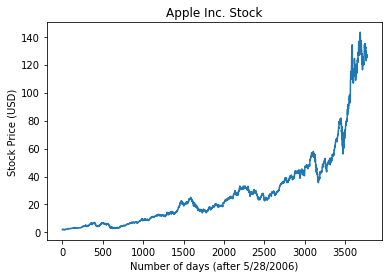

In [ ]:
plot_stock("AAPL")

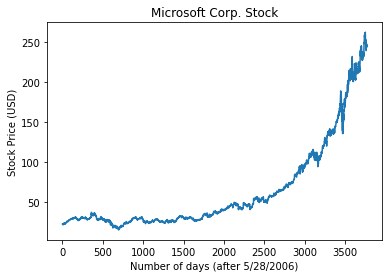

In [ ]:
plot_stock("MSFT")

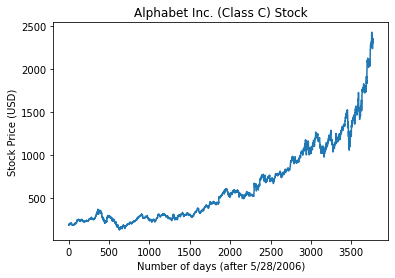

In [ ]:
plot_stock("GOOG")

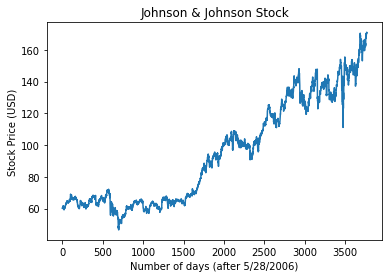

In [ ]:
plot_stock("JNJ")

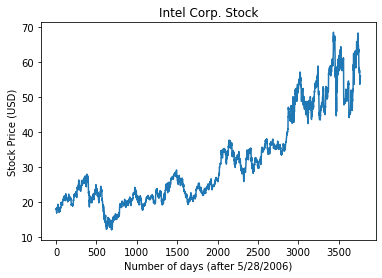

In [ ]:
plot_stock("INTC")

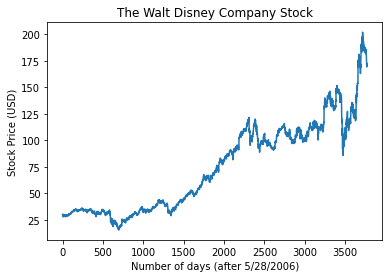

In [ ]:
plot_stock("DIS")

# Train Deep Q-Learning Model

In [ ]:
num_days_per_company = 30

In [ ]:
input_shape = num_days_per_company*len(companies)
print(input_shape)
output_shape = len(companies)
print(output_shape)

6150
205


In [ ]:
def make_model(layers=[100, 100, 100], # number of hidden layers and number of neurons for hidden layers
               input_shape=input_shape, # input shape of model
               output_shape=output_shape, # output shape of model
               lr=0.001, # learning rate
               kernel_initializer=HeUniform, # kernel initializer
               hidden_activation='relu', # activation function for hidden layers
               output_activation='linear', # activation function for output layer
               loss=Huber,
               optimizer=Adam,
               metrics='accuracy'
              ):
  if not isinstance(metrics, list):
    metrics = [metrics]
  input_layer = Input(shape=input_shape)
  model = input_layer
  for layer in layers:
    model = Dense(units=layer, activation=hidden_activation, kernel_initializer=kernel_initializer())(model)
  model = Dense(output_shape, activation=output_activation, kernel_initializer=kernel_initializer())(model)
  model = Model(input_layer, model)
  model.compile(loss=loss(), optimizer=optimizer(lr=lr), metrics=metrics)
  return model

In [ ]:
make_model().summary()

Model: "model_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        [(None, 6150)]            0         
_________________________________________________________________
dense_277 (Dense)            (None, 100)               615100    
_________________________________________________________________
dense_278 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_279 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_280 (Dense)            (None, 205)               20705     
Total params: 656,005
Trainable params: 656,005
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: model_2_test/assets


In [ ]:
"""
x = []
y = []
"""

In [ ]:
"""
for i in range(num_days_per_company, len(companies[0].stock)):
  x_i = []
  y_i = []
  for j in range(len(companies)):
    x_i.extend(companies[j].stock[i-num_days_per_company:i])
    y_i.append(companies[j].stock[i])
  x.append(x_i)
  y.append(y_i)
"""

In [ ]:
"""
x = np.array(x)
y = np.array(y)
"""

In [ ]:
"""
print(x.shape)
print(y.shape)
"""

(3741, 6150)
(3741, 205)


In [ ]:
"""
np.save(drive_dir+"x.npy", x)
np.save(drive_dir+"y.npy", y)
"""

In [ ]:
train_portion = 2.0/3.0
val_portion = 1.0/6.0
test_portion = 1.0/6.0

In [ ]:
train_idx = int(x.shape[0]*train_portion)
val_idx = int(x.shape[0]*val_portion)+train_idx
test_idx = x.shape[0]+1

In [ ]:
"""
x_train = x[:train_idx]
x_val = x[train_idx:val_idx]
x_test = x[val_idx:test_idx]
"""

In [ ]:
"""
y_train = y[:train_idx]
y_val = y[train_idx:val_idx]
y_test = y[val_idx:test_idx]
"""

In [ ]:
"""
print(x_train.shape)
print(y_train.shape)
"""

(2494, 6150)
(2494, 205)


In [ ]:
"""
print(x_val.shape)
print(y_val.shape)
"""

(623, 6150)
(623, 205)


In [ ]:
"""
print(x_test.shape)
print(y_test.shape)
"""

(624, 6150)
(624, 205)


In [ ]:
"""
normalizer_x = Normalizer()
normalizer_y = Normalizer()
"""

In [ ]:
"""
x_train = normalizer_x.fit_transform(x_train)
y_train = normalizer_y.fit_transform(y_train)

x_val = normalizer_x.transform(x_val)
y_val = normalizer_y.transform(y_val)

x_test = normalizer_x.transform(x_test)
y_test = normalizer_y.transform(y_test)
"""

In [ ]:
"""
dump(normalizer_x, open(drive_dir+'normalizer_x.pkl', 'wb'))
dump(normalizer_y, open(drive_dir+'normalizer_y.pkl', 'wb'))
"""

In [ ]:
"""
np.save(drive_dir+"x_train.npy", x_train)
np.save(drive_dir+"y_train.npy", y_train)

np.save(drive_dir+"x_val.npy", x_val)
np.save(drive_dir+"y_val.npy", y_val)

np.save(drive_dir+"x_test.npy", x_test)
np.save(drive_dir+"y_test.npy", y_test)
"""

In [ ]:
def get_q_values(model, stock):
  return model.predict(np.array([stock]))[0]

In [ ]:
def train(replay_memory, model, target_model, end, lr=0.7, discount=0.618, min_replay_size=1000, batch_size=128):

    if len(replay_memory) < min_replay_size:
        return

    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list = model.predict(current_states)
    new_current_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = target_model.predict(new_current_states)

    X = []
    Y = []
    for index, (observation, action, reward, new_observation, end) in enumerate(mini_batch):
        if not end:
            max_future_q = reward + discount * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - lr) * current_qs[action] + lr * max_future_q

        X.append(observation)
        Y.append(current_qs)
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

In [ ]:
def tanh(x):
  return (np.exp(2*x)-1)/(np.exp(2*x)+1)

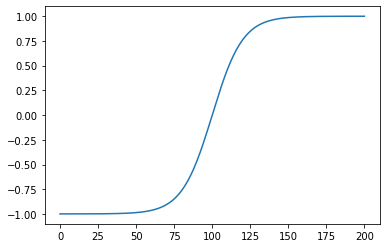

In [ ]:
plt.plot([tanh(0.05*i) for i in range(-100, 101)])

In [ ]:
def step(i, action, a=0.05):
  stock_price = x_train[i][num_days_per_company*action + num_days_per_company - 1]
  next_day_stock_price = y_train[i][action]
  diff = next_day_stock_price - stock_price
  percent_diff = diff/stock_price
  reward = tanh(a*percent_diff)
  done = False
  new_i = i+1
  if new_i >= x_train.shape[0]-1:
    done = True
  new_observation = x_train[new_i]
  return [new_i, new_observation, reward, done]

In [ ]:
def fit_model(
    layers=[100, 100, 100], # hidden layers for model
    train_episodes = 30,
    epsilon=1, # initial epsilon value
    max_epsilon=1, # maximum epsilon value
    min_epsilon=0.01, # minimum epsilon value
    decay = 0.01,
    update=4, # updates model every update steps
    target_update=100 # updates target_model every target_update steps
):

  model = make_model(layers=layers)
  target_model = make_model(layers=layers)
  target_model.set_weights(model.get_weights())

  replay_memory = deque(maxlen=50000)

  target_update_counter = 0

  X = []
  y = []

  steps = 0

  for episode in range(train_episodes):
      total_training_rewards = 0
      i = 0
      observation = x_train[i]
      done = False
      while not done:
          progress_bar = list('**********')
          for k in range(int(10*i/x_train.shape[0])):
            progress_bar[k] = '-'
          progress_bar = "".join(progress_bar)
          print(f"Episode {episode+1}/{train_episodes}: {i}/{x_train.shape[0]} {progress_bar[:5]}{round(100*i/x_train.shape[0], 2)}%{progress_bar[5:]}")
          steps += 1

          random_number = np.random.rand()
          if random_number <= epsilon:
              action = np.random.randint(len(companies))
          else:
              predicted = get_q_values(model, observation)
              action = np.argmax(predicted)
          new_i, new_observation, reward, done = step(i, action)
          replay_memory.append([observation, action, reward, new_observation, done])

          # 3. Update the Main Network using the Bellman Equation
          if steps % update == 0 or done:
              train(replay_memory, model, target_model, done)

          observation = new_observation
          i = new_i
          total_training_rewards += reward

          if done:
              print('Total training rewards: {} after n steps = {} with final reward = {}'.format(total_training_rewards, episode, reward))
              total_training_rewards += 1

              if steps >= 100:
                  print('Copying main network weights to the target network weights')
                  target_model.set_weights(model.get_weights())
                  steps = 0
              break

      epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
  return model, target_model

In [ ]:
# models = []

In [ ]:
"""
for i in range(1, 5): # number of 100 neuron hidden layers for model
  model, target_model = fit_model(layers=[100 for k in range(i)])
  model.save(drive_dir+f"model_{i}")
  models.append(model)
"""

Streaming output truncated to the last 5000 lines.
Episode 28/30: 2486/2494 -----99.68%----*
Episode 28/30: 2487/2494 -----99.72%----*
Episode 28/30: 2488/2494 -----99.76%----*
Episode 28/30: 2489/2494 -----99.8%----*
Episode 28/30: 2490/2494 -----99.84%----*
Episode 28/30: 2491/2494 -----99.88%----*
Episode 28/30: 2492/2494 -----99.92%----*
Total training rewards: 549.5802711986884 after n steps = 27 with final reward = 0.2187912620635053
Copying main network weights to the target network weights
Episode 29/30: 0/2494 *****0.0%*****
Episode 29/30: 1/2494 *****0.04%*****
Episode 29/30: 2/2494 *****0.08%*****
Episode 29/30: 3/2494 *****0.12%*****
Episode 29/30: 4/2494 *****0.16%*****
Episode 29/30: 5/2494 *****0.2%*****
Episode 29/30: 6/2494 *****0.24%*****
Episode 29/30: 7/2494 *****0.28%*****
Episode 29/30: 8/2494 *****0.32%*****
Episode 29/30: 9/2494 *****0.36%*****
Episode 29/30: 10/2494 *****0.4%*****
Episode 29/30: 11/2494 *****0.44%*****
Episode 29/30: 12/2494 *****0.48%*****
Epi

# Load data and models

In [ ]:
normalizer_x = load(open(drive_dir+"normalizer_x.pkl", "rb"))
normalizer_y = load(open(drive_dir+"normalizer_y.pkl", "rb"))

In [ ]:
x = np.load(drive_dir+"x.npy")
y = np.load(drive_dir+"y.npy")

x_train = np.load(drive_dir+"x_train.npy")
y_train = np.load(drive_dir+"y_train.npy")

x_val = np.load(drive_dir+"x_val.npy")
y_val = np.load(drive_dir+"y_val.npy")

x_test = np.load(drive_dir+"x_test.npy")
y_test = np.load(drive_dir+"y_test.npy")

In [ ]:
models = []

In [ ]:
for i in range(1, 5):
  models.append(keras.models.load_model(drive_dir+f"model_{i}"))

# Test Deep Q-Learning Models on Validation Set

In [ ]:
def stock_growth(company, i, j):
  return companies[company].stock[j]/companies[company].stock[i]

In [ ]:
def invest(model, stocks):
  return np.argmax(model.predict(np.array([stocks]))[0])

In [ ]:
def get_balances(model, stocks_x, buffer_idx):
  balances = []
  balance = 1
  balances.append(balance)
  for i in range(stocks_x.shape[0]-1):
    balance *= stock_growth(invest(model, stocks_x[i]), i+buffer_idx+num_days_per_company, i+buffer_idx+num_days_per_company+1)
    balances.append(balance)
  return (balances, balance)

In [ ]:
balances = []
final_balances = []

In [ ]:
for i in range(len(models)):
  balances_i, final_balance_i = get_balances(models[i], x_val, train_idx)
  balances.append(balances_i)
  final_balances.append(final_balance_i)

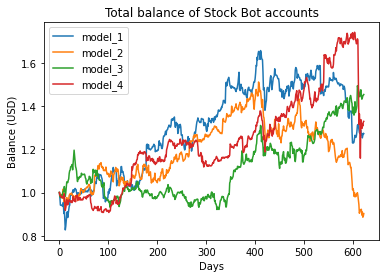

In [ ]:
for balance in balances:
  plt.plot(balance)
plt.title("Total balance of Stock Bot accounts")
plt.ylabel("Balance (USD)")
plt.xlabel("Days")
plt.legend([f"model_{i+1}" for i in range(len(models))])
plt.show()

Final balance for model_1: 1.2726472913661824
Final balance for model_2: 0.9025167711931644
Final balance for model_3: 1.454180194785426
Final balance for model_4: 1.3297656946515373


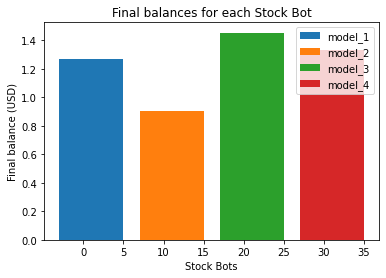

In [ ]:
bar_width = 10
for i, final_balance in enumerate(final_balances):
  print(f"Final balance for model_{i+1}: {final_balance}")
  plt.bar((i+0.1)*bar_width, final_balance, width=0.8*bar_width)
plt.xlabel("Stock Bots")
plt.ylabel("Final balance (USD)")
plt.legend([f"model_{i+1}" for i in range(len(models))])
plt.title("Final balances for each Stock Bot")
plt.show()

Percent return over 623 days for model_1: 27.264729136618236%
Percent return over 623 days for model_2: -9.748322880683558%
Percent return over 623 days for model_3: 45.418019478542604%
Percent return over 623 days for model_4: 32.97656946515373%


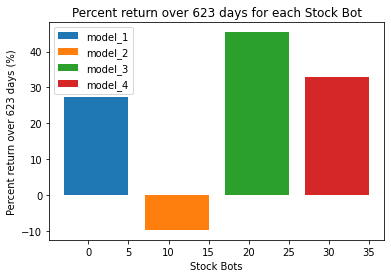

In [ ]:
bar_width = 10
for i, final_balance in enumerate(final_balances):
  print(f"Percent return over 623 days for model_{i+1}: {100*(final_balance-1)}%")
  plt.bar((i+0.1)*bar_width, 100*(final_balance-1), width=0.8*bar_width)
plt.xlabel("Stock Bots")
plt.ylabel("Percent return over 623 days (%)")
plt.legend([f"model_{i+1}" for i in range(len(models))])
plt.title("Percent return over 623 days for each Stock Bot")
plt.show()

Average daily percent return: 0.038707202361898396%
Average daily percent return: -0.01646220918085639%
Average daily percent return: 0.06012116373690368%
Average daily percent return: 0.04575729648248483%


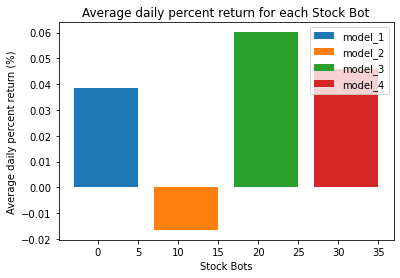

In [ ]:
bar_width = 10
for i, final_balance in enumerate(final_balances):
  print(f"Average daily percent return: {100*(final_balance**(1/x_val.shape[0])-1)}%")
  plt.bar((i+0.1)*bar_width, 100*(final_balance**(1/x_val.shape[0])-1), width=0.8*bar_width)
plt.xlabel("Stock Bots")
plt.ylabel("Average daily percent return (%)")
plt.legend([f"model_{i+1}" for i in range(len(models))])
plt.title("Average daily percent return for each Stock Bot")
plt.show()

Average yearly percent return: 15.171709246599608%
Average yearly percent return: -5.832211407311272%
Average yearly percent return: 24.529980536686512%
Average yearly percent return: 18.17258246511706%


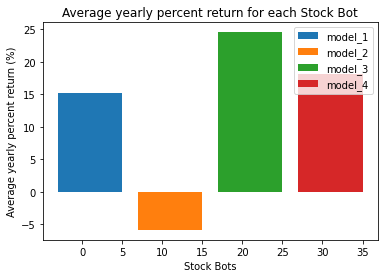

In [ ]:
bar_width = 10
for i, final_balance in enumerate(final_balances):
  print(f"Average yearly percent return: {100*(final_balance**(365/x_val.shape[0])-1)}%")
  plt.bar((i+0.1)*bar_width, 100*(final_balance**(365/x_val.shape[0])-1), width=0.8*bar_width)
plt.xlabel("Stock Bots")
plt.ylabel("Average yearly percent return (%)")
plt.legend([f"model_{i+1}" for i in range(len(models))])
plt.title("Average yearly percent return for each Stock Bot")
plt.show()

Best model: model_3

# Test Best Model (model_3) on Test Set

In [ ]:
best_model = 2 # determined to be the best model based on performance on the validation set

In [ ]:
balance, final_balance = get_balances(models[best_model], x_test, val_idx)

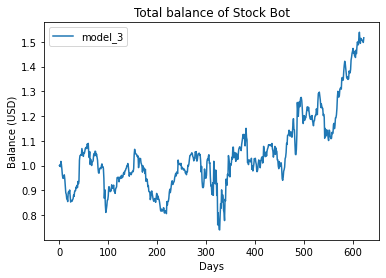

In [ ]:
plt.plot(balance)
plt.title("Total balance of Stock Bot")
plt.ylabel("Balance (USD)")
plt.xlabel("Days")
plt.legend([f"model_{best_model+1}"])
plt.show()

In [ ]:
print(f"Final balance for model_{best_model+1}: {final_balance}")
print(f"Percent return over 623 days for model_{i+1}: {100*(final_balance-1)}%")
print(f"Average daily percent return: {100*(final_balance**(1/x_val.shape[0])-1)}%")
print(f"Average yearly percent return: {100*(final_balance**(365/x_val.shape[0])-1)}%")

Final balance for model_3: 1.5159985887840186
Percent return over 623 days for model_5: 51.59985887840186%
Average daily percent return: 0.06680791752400328%
Average yearly percent return: 27.604758945441986%


In [ ]:
print(companies[invest(models[best_model], x_test[-1])].name) # company that the model recommends investing in today

Anthem
